# Libraries

In [66]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

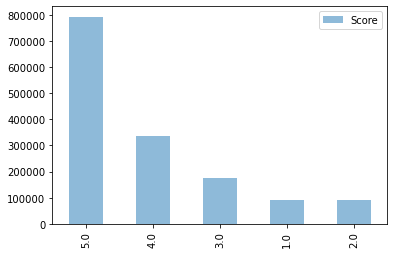


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [67]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [68]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Adding text length features

    df['text_length'] = df['Text'].fillna('').str.len()
    df['summary_length'] = df['Summary'].fillna('').str.len()
    df['word_count'] = df['Text'].fillna('').str.split().str.len()
    df['avg_word_length'] = df['text_length'] / df['word_count']

    # Count punctuation
    
    df['exclamation_count'] = df['Text'].fillna('').str.count('!')
    df['question_count'] = df['Text'].fillna('').str.count('\?')
    df['caps_count'] = df['Text'].fillna('').apply(lambda x: sum(1 for c in str(x) if c.isupper()))

    # Simple sentiment analysis using word counts
    positive_words = ['great', 'good', 'excellent', 'amazing', 'wonderful', 'best', 'love', 'perfect',
                     'awesome', 'fantastic', 'superb', 'outstanding', 'brilliant', 'superb', 'delightful',
                     'masterpiece', 'incredible', 'magnificent', 'favorite', 'recommend']
    
    negative_words = ['bad', 'poor', 'terrible', 'awful', 'worst', 'hate', 'disappointing',
                     'waste', 'boring', 'stupid', 'horrible', 'mediocre', 'rubbish', 'disaster',
                     'pathetic', 'dreadful', 'avoid', 'mess', 'failure', 'unwatchable']
    
    # Handle negations
    negation_words = ['not', "n't", 'never', 'no', 'none', 'nobody', 'nothing', 'neither', 'nowhere']

    def sentiment_score(text):
        text = str(text).lower()
        words = text.split()
        score = 0
        negation = False
        
        for i, word in enumerate(words):
            # Check for negation
            if word in negation_words:
                negation = True
                continue
                
            # Reset negation after punctuation
            if any(p in word for p in '.!?'):
                negation = False
            
            # Calculate sentiment
            if word in positive_words:
                score += -1 if negation else 1
            elif word in negative_words:
                score += 1 if negation else -1
                
            # Reset negation after 3 words
            if i > 0 and i % 3 == 0:
                negation = False
                
        return score
    
    df['sentiment_score'] = df['Text'].apply(sentiment_score)
    
    # Fill NaN values - handle numeric columns specifically
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
    X_train = add_features_to(X_train)
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")
    X_submission = add_features_to(X_submission)

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [69]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'].astype(int),
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [70]:
features = ['HelpfulnessNumerator',
            'HelpfulnessDenominator',
            'Time',
            'Helpfulness',
            'text_length',
            'summary_length',
            'word_count',
            'avg_word_length',
            'exclamation_count',
            'question_count',
            'caps_count',
            'sentiment_score',
            ]

scaler = StandardScaler()

X_train_select = scaler.fit_transform(X_train[features])
X_test_select = scaler.transform(X_test[features])
X_submission_select = scaler.transform(X_submission[features])

# Model Creation

In [71]:
# Learn the model
model = KNeighborsClassifier(n_neighbors=5).fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

# Model Evaluation

Accuracy on testing set =  0.43739160760066353


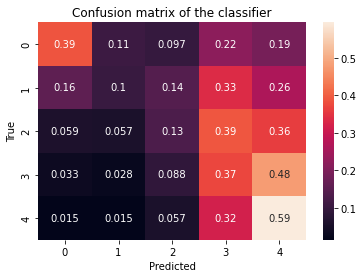

In [72]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [73]:
# First check and handle any NaN values in scaled features
# X_submission_select = np.nan_to_num(X_submission_select, 0)  # Replace NaN with 0

# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)